<a href="https://colab.research.google.com/github/Leafmun-certii/complimentory-protein-caculator/blob/main/complimentory_protein_caculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Protein Complementarity Calculator
# Finding Optimal Combinations of Incomplete Proteins

!pip install pandas numpy matplotlib seaborn scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
## 1. Amino Acid Reference Pattern (WHO/FAO 2013)

# Essential amino acid requirements (mg/g protein) for adults
reference_pattern = {
    'Histidine': 18,
    'Isoleucine': 25,
    'Leucine': 59,
    'Lysine': 45,
    'Methionine_Cysteine': 22,  # Combined sulfur amino acids
    'Phenylalanine_Tyrosine': 38,  # Combined aromatic amino acids
    'Threonine': 23,
    'Tryptophan': 6,
    'Valine': 39
}

print("WHO/FAO Reference Pattern (mg/g protein):")
for aa, value in reference_pattern.items():
    print(f"{aa:<25}: {value:>3} mg/g")


WHO/FAO Reference Pattern (mg/g protein):
Histidine                :  18 mg/g
Isoleucine               :  25 mg/g
Leucine                  :  59 mg/g
Lysine                   :  45 mg/g
Methionine_Cysteine      :  22 mg/g
Phenylalanine_Tyrosine   :  38 mg/g
Threonine                :  23 mg/g
Tryptophan               :   6 mg/g
Valine                   :  39 mg/g


In [3]:
## 2. Amino Acid Profiles of Common Proteins

# Amino acid content (mg/g protein) - based on USDA data
protein_profiles = {
    'Rice': {
        'Histidine': 23, 'Isoleucine': 33, 'Leucine': 66, 'Lysine': 29,  # Low lysine!
        'Methionine_Cysteine': 35, 'Phenylalanine_Tyrosine': 51,
        'Threonine': 28, 'Tryptophan': 9, 'Valine': 46
    },
    'Beans': {
        'Histidine': 30, 'Isoleucine': 42, 'Leucine': 71, 'Lysine': 63,  # High lysine!
        'Methionine_Cysteine': 15, 'Phenylalanine_Tyrosine': 49,  # Low methionine!
        'Threonine': 38, 'Tryptophan': 10, 'Valine': 48
    },
    'Corn': {
        'Histidine': 26, 'Isoleucine': 28, 'Leucine': 95, 'Lysine': 21,  # Very low lysine!
        'Methionine_Cysteine': 40, 'Phenylalanine_Tyrosine': 72,
        'Threonine': 30, 'Tryptophan': 4, 'Valine': 38  # Low tryptophan!
    },
    'Peanuts': {
        'Histidine': 24, 'Isoleucine': 35, 'Leucine': 63, 'Lysine': 32,  # Low lysine
        'Methionine_Cysteine': 25, 'Phenylalanine_Tyrosine': 95,
        'Threonine': 24, 'Tryptophan': 11, 'Valine': 43
    },
    'Quinoa': {
        'Histidine': 31, 'Isoleucine': 42, 'Leucine': 68, 'Lysine': 51,  # Good lysine!
        'Methionine_Cysteine': 28, 'Phenylalanine_Tyrosine': 69,
        'Threonine': 38, 'Tryptophan': 13, 'Valine': 46
    },
    'Lentils': {
        'Histidine': 31, 'Isoleucine': 45, 'Leucine': 73, 'Lysine': 69,  # High lysine!
        'Methionine_Cysteine': 9, 'Phenylalanine_Tyrosine': 53,  # Very low methionine!
        'Threonine': 36, 'Tryptophan': 9, 'Valine': 49
    }
}

# Convert to DataFrame for easier analysis
df_proteins = pd.DataFrame(protein_profiles).T
df_reference = pd.Series(reference_pattern)

print("\nAmino Acid Profiles (mg/g protein):")
print(df_proteins)


Amino Acid Profiles (mg/g protein):
         Histidine  Isoleucine  Leucine  Lysine  Methionine_Cysteine  \
Rice            23          33       66      29                   35   
Beans           30          42       71      63                   15   
Corn            26          28       95      21                   40   
Peanuts         24          35       63      32                   25   
Quinoa          31          42       68      51                   28   
Lentils         31          45       73      69                    9   

         Phenylalanine_Tyrosine  Threonine  Tryptophan  Valine  
Rice                         51         28           9      46  
Beans                        49         38          10      48  
Corn                         72         30           4      38  
Peanuts                      95         24          11      43  
Quinoa                       69         38          13      46  
Lentils                      53         36           9      49  


In [5]:
## 3. Calculate Amino Acid Scores
def calculate_amino_acid_scores(protein_profile, reference):
    """Calculate amino acid score for each essential amino acid"""
    scores = {}
    for aa in reference.index:
        if aa in protein_profile.index:
            scores[aa] = (protein_profile[aa] / reference[aa]) * 100
        else:
            scores[aa] = 0
    return pd.Series(scores)

def get_limiting_amino_acid(scores):
    """Find the limiting amino acid (lowest score)"""
    limiting_aa = scores.idxmin()
    limiting_score = scores.min()
    return limiting_aa, limiting_score

# Calculate scores for all proteins
protein_scores = {}
limiting_amino_acids = {}

print("\n" + "="*60)
print("AMINO ACID SCORES (% of requirement met)")
print("="*60)

for protein in df_proteins.index:
    scores = calculate_amino_acid_scores(df_proteins.loc[protein], df_reference)
    protein_scores[protein] = scores
    limiting_aa, limiting_score = get_limiting_amino_acid(scores)
    limiting_amino_acids[protein] = (limiting_aa, limiting_score)

    print(f"\n{protein}:")
    for aa, score in scores.items():
        marker = " ←LIMITING" if aa == limiting_aa else ""
        print(f"  {aa:<25}: {score:>6.1f}%{marker}")
    print(f"  Overall Score (PDCAAS): {limiting_score:.1f}%")



AMINO ACID SCORES (% of requirement met)

Rice:
  Histidine                :  127.8%
  Isoleucine               :  132.0%
  Leucine                  :  111.9%
  Lysine                   :   64.4% ←LIMITING
  Methionine_Cysteine      :  159.1%
  Phenylalanine_Tyrosine   :  134.2%
  Threonine                :  121.7%
  Tryptophan               :  150.0%
  Valine                   :  117.9%
  Overall Score (PDCAAS): 64.4%

Beans:
  Histidine                :  166.7%
  Isoleucine               :  168.0%
  Leucine                  :  120.3%
  Lysine                   :  140.0%
  Methionine_Cysteine      :   68.2% ←LIMITING
  Phenylalanine_Tyrosine   :  128.9%
  Threonine                :  165.2%
  Tryptophan               :  166.7%
  Valine                   :  123.1%
  Overall Score (PDCAAS): 68.2%

Corn:
  Histidine                :  144.4%
  Isoleucine               :  112.0%
  Leucine                  :  161.0%
  Lysine                   :   46.7% ←LIMITING
  Methionine_Cysteine      :

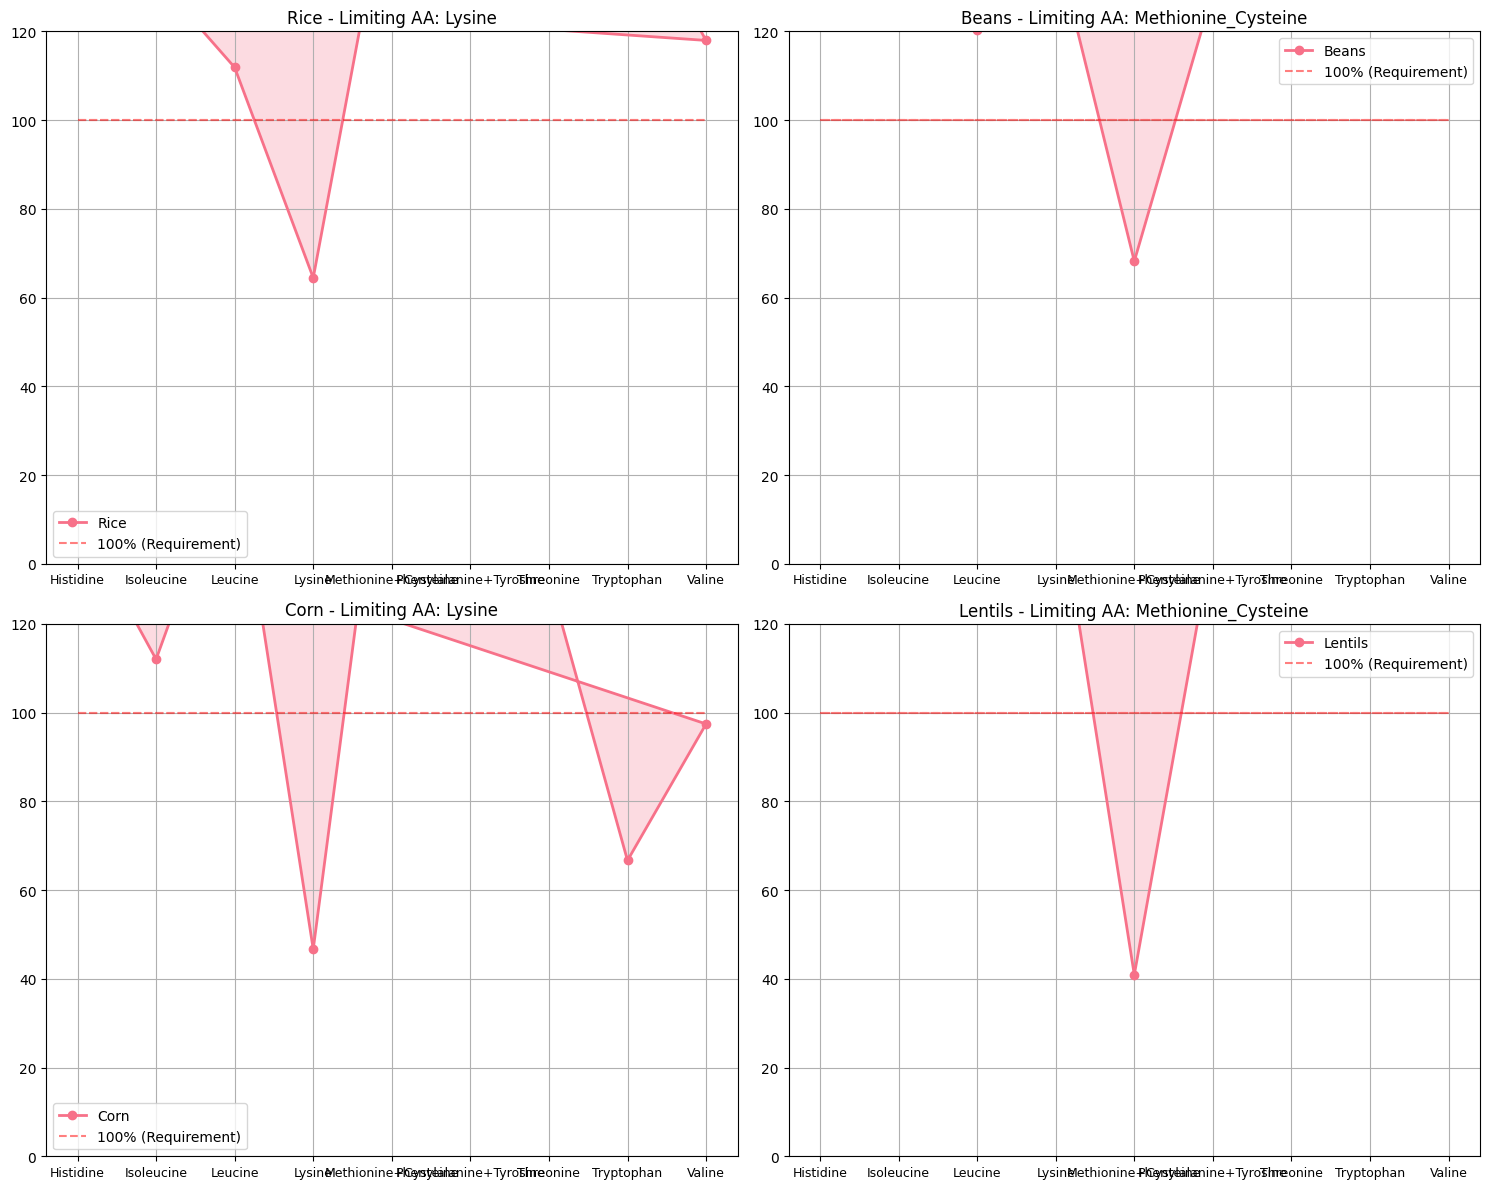

In [6]:
## 4. Visualization of Amino Acid Profiles

def plot_amino_acid_profiles(proteins_to_plot):
    """Create radar chart comparing amino acid profiles"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    amino_acids = list(reference_pattern.keys())
    angles = np.linspace(0, 2*np.pi, len(amino_acids), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    for idx, protein in enumerate(proteins_to_plot[:4]):
        ax = axes[idx]

        # Get scores for this protein
        scores = protein_scores[protein].values.tolist()
        scores += scores[:1]  # Complete the circle

        # Plot
        ax.plot(angles, scores, 'o-', linewidth=2, label=protein)
        ax.fill(angles, scores, alpha=0.25)
        ax.plot(angles, [100]*len(angles), 'r--', alpha=0.5, label='100% (Requirement)')

        # Customize
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([aa.replace('_', '+') for aa in amino_acids], fontsize=9)
        ax.set_ylim(0, 120)
        ax.set_title(f'{protein} - Limiting AA: {limiting_amino_acids[protein][0]}', fontsize=12)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_amino_acid_profiles(['Rice', 'Beans', 'Corn', 'Lentils'])

In [7]:
## 5. Find Complementary Protein Pairs

def find_complementary_pairs():
    """Identify which proteins complement each other well"""
    complementary_pairs = []

    proteins = list(protein_profiles.keys())

    for i, protein1 in enumerate(proteins):
        for protein2 in proteins[i+1:]:
            # Get limiting amino acids
            limiting1 = limiting_amino_acids[protein1][0]
            limiting2 = limiting_amino_acids[protein2][0]

            # Check if they complement each other
            score1_in_protein2 = protein_scores[protein2][limiting1]
            score2_in_protein1 = protein_scores[protein1][limiting2]

            # Calculate complementarity score
            complementarity = min(score1_in_protein2, score2_in_protein1)

            complementary_pairs.append({
                'Protein1': protein1,
                'Protein2': protein2,
                'Limiting1': limiting1,
                'Limiting2': limiting2,
                'Complementarity': complementarity
            })

    return pd.DataFrame(complementary_pairs).sort_values('Complementarity', ascending=False)

complementary_df = find_complementary_pairs()

print("\n" + "="*60)
print("PROTEIN COMPLEMENTARITY ANALYSIS")
print("="*60)
print("(Higher complementarity score = better combination)")
print(complementary_df)


PROTEIN COMPLEMENTARITY ANALYSIS
(Higher complementarity score = better combination)
   Protein1 Protein2            Limiting1            Limiting2  \
4      Rice  Lentils               Lysine  Methionine_Cysteine   
11     Corn  Lentils               Lysine  Methionine_Cysteine   
5     Beans     Corn  Methionine_Cysteine               Lysine   
0      Rice    Beans               Lysine  Methionine_Cysteine   
7     Beans   Quinoa  Methionine_Cysteine               Lysine   
14   Quinoa  Lentils               Lysine  Methionine_Cysteine   
6     Beans  Peanuts  Methionine_Cysteine               Lysine   
13  Peanuts  Lentils               Lysine  Methionine_Cysteine   
12  Peanuts   Quinoa               Lysine               Lysine   
2      Rice  Peanuts               Lysine               Lysine   
3      Rice   Quinoa               Lysine               Lysine   
1      Rice     Corn               Lysine               Lysine   
9      Corn  Peanuts               Lysine               

In [10]:
## 6. Optimize Protein Combinations

def optimize_protein_combination(protein1, protein2, target_score=100):
    """
    Find optimal ratio of two proteins to maximize the limiting amino acid score
    Returns the ratio as (fraction_protein1, fraction_protein2)
    """

    def objective(ratio):
        """Minimize the negative of the limiting amino acid score"""
        r1 = ratio  # Use the scalar value directly
        r2 = 1 - r1  # r2 = 1 - r1 to ensure they sum to 1

        # Calculate combined amino acid profile
        combined_scores = []
        for aa in df_reference.index:
            combined_content = (r1 * df_proteins.loc[protein1, aa] +
                              r2 * df_proteins.loc[protein2, aa])
            combined_score = (combined_content / df_reference[aa]) * 100
            combined_scores.append(combined_score)

        # Return negative of limiting amino acid score (since we minimize)
        return -min(combined_scores)

    # Optimize ratio (constrained between 0 and 1)
    from scipy.optimize import minimize_scalar

    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')

    optimal_ratio1 = result.x
    optimal_ratio2 = 1 - optimal_ratio1
    optimal_score = -result.fun

    return optimal_ratio1, optimal_ratio2, optimal_score

# Calculate optimal combinations for top complementary pairs
print("\n" + "="*70)
print("OPTIMAL PROTEIN COMBINATIONS")
print("="*70)

top_pairs = complementary_df.head(3)  # Top 3 complementary pairs

for idx, row in top_pairs.iterrows():
    protein1, protein2 = row['Protein1'], row['Protein2']

    ratio1, ratio2, score = optimize_protein_combination(protein1, protein2)

    print(f"\n{protein1} + {protein2}:")
    print(f"  Optimal ratio: {ratio1:.1%} {protein1} + {ratio2:.1%} {protein2}")
    print(f"  Combined PDCAAS: {score:.1f}%")
    print(f"  Practical ratio: ~{ratio1*4:.0f} parts {protein1} to {ratio2*4:.0f} parts {protein2}")


OPTIMAL PROTEIN COMBINATIONS

Rice + Lentils:
  Optimal ratio: 54.3% Rice + 45.7% Lentils
  Combined PDCAAS: 105.1%
  Practical ratio: ~2 parts Rice to 2 parts Lentils

Corn + Lentils:
  Optimal ratio: 45.4% Corn + 54.6% Lentils
  Combined PDCAAS: 104.9%
  Practical ratio: ~2 parts Corn to 2 parts Lentils

Beans + Corn:
  Optimal ratio: 65.3% Beans + 34.7% Corn
  Combined PDCAAS: 107.6%
  Practical ratio: ~3 parts Beans to 1 parts Corn


In [11]:
## 7. Detailed Analysis of Best Combination

def analyze_combination(protein1, protein2, ratio1, ratio2):
    """Provide detailed analysis of a protein combination"""

    print(f"\n" + "="*70)
    print(f"DETAILED ANALYSIS: {ratio1:.0%} {protein1} + {ratio2:.0%} {protein2}")
    print("="*70)

    # Calculate combined profile
    combined_profile = {}
    combined_scores = {}

    for aa in df_reference.index:
        combined_content = (ratio1 * df_proteins.loc[protein1, aa] +
                          ratio2 * df_proteins.loc[protein2, aa])
        combined_profile[aa] = combined_content
        combined_scores[aa] = (combined_content / df_reference[aa]) * 100

    # Create comparison table
    comparison_data = {
        f'{protein1} alone': protein_scores[protein1],
        f'{protein2} alone': protein_scores[protein2],
        'Combined': pd.Series(combined_scores),
        'Requirement': df_reference
    }

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df['Improvement'] = comparison_df['Combined'] - comparison_df[[f'{protein1} alone', f'{protein2} alone']].max(axis=1)

    print("\nAmino Acid Score Comparison (% of requirement):")
    print("-" * 70)

    for aa in df_reference.index:
        p1_score = comparison_df.loc[aa, f'{protein1} alone']
        p2_score = comparison_df.loc[aa, f'{protein2} alone']
        combined_score = comparison_df.loc[aa, 'Combined']
        improvement = comparison_df.loc[aa, 'Improvement']

        print(f"{aa:<25}: {p1_score:>6.1f}% + {p2_score:>6.1f}% = {combined_score:>6.1f}% ({improvement:+5.1f}%)")

    limiting_combined = comparison_df['Combined'].min()
    limiting_aa_combined = comparison_df['Combined'].idxmin()

    print(f"\nLimiting amino acid: {limiting_aa_combined}")
    print(f"Overall PDCAAS: {limiting_combined:.1f}%")

    # Practical serving suggestions
    print(f"\n" + "="*50)
    print("PRACTICAL SERVING SUGGESTIONS")
    print("="*50)

    if protein1 == 'Rice' and protein2 == 'Beans':
        print(f"• {ratio1:.1%} Rice + {ratio2:.1%} Beans")
        print(f"• Example: {ratio1*200:.0f}g cooked rice + {ratio2*200:.0f}g cooked beans")
        print("• This is close to traditional rice and beans ratios!")
    elif protein1 == 'Corn' and protein2 == 'Beans':
        print(f"• {ratio1:.1%} Corn + {ratio2:.1%} Beans")
        print(f"• Example: {ratio1*200:.0f}g corn + {ratio2*200:.0f}g beans")
    else:
        print(f"• {ratio1:.1%} {protein1} + {ratio2:.1%} {protein2}")
        print(f"• Example serving: {ratio1*100:.0f}g {protein1} + {ratio2*100:.0f}g {protein2}")

# Analyze the best combination
best_pair = complementary_df.iloc[0]
protein1, protein2 = best_pair['Protein1'], best_pair['Protein2']
ratio1, ratio2, _ = optimize_protein_combination(protein1, protein2)
analyze_combination(protein1, protein2, ratio1, ratio2)


DETAILED ANALYSIS: 54% Rice + 46% Lentils

Amino Acid Score Comparison (% of requirement):
----------------------------------------------------------------------
Histidine                :  127.8% +  172.2% =  148.1% (-24.1%)
Isoleucine               :  132.0% +  180.0% =  153.9% (-26.1%)
Leucine                  :  111.9% +  123.7% =  117.3% ( -6.4%)
Lysine                   :   64.4% +  153.3% =  105.1% (-48.3%)
Methionine_Cysteine      :  159.1% +   40.9% =  105.1% (-54.0%)
Phenylalanine_Tyrosine   :  134.2% +  139.5% =  136.6% ( -2.9%)
Threonine                :  121.7% +  156.5% =  137.6% (-18.9%)
Tryptophan               :  150.0% +  150.0% =  150.0% ( +0.0%)
Valine                   :  117.9% +  125.6% =  121.5% ( -4.2%)

Limiting amino acid: Lysine
Overall PDCAAS: 105.1%

PRACTICAL SERVING SUGGESTIONS
• 54.3% Rice + 45.7% Lentils
• Example serving: 54g Rice + 46g Lentils


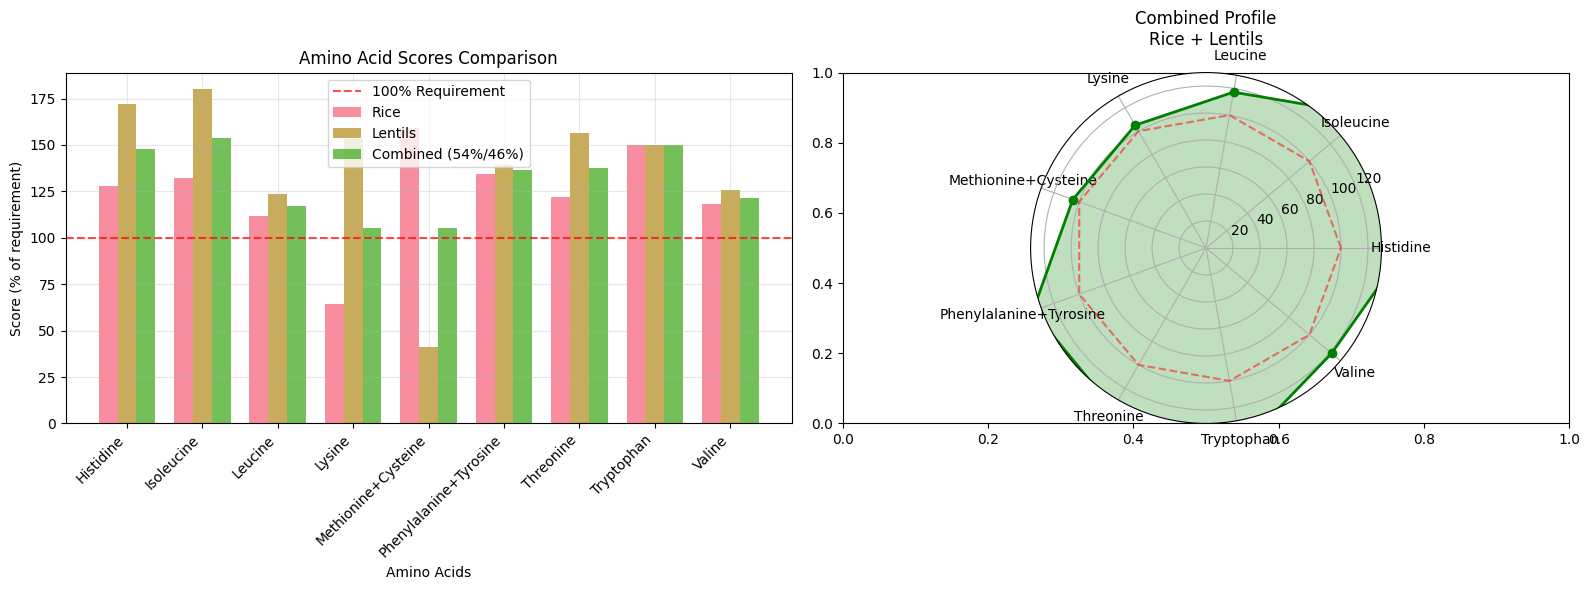

In [12]:
## 8. Visualization of Best Combination

def plot_combination_comparison(protein1, protein2, ratio1, ratio2):
    """Create visualization comparing individual proteins vs combination"""

    # Calculate combined scores
    combined_scores = []
    for aa in df_reference.index:
        combined_content = (ratio1 * df_proteins.loc[protein1, aa] +
                          ratio2 * df_proteins.loc[protein2, aa])
        combined_score = (combined_content / df_reference[aa]) * 100
        combined_scores.append(combined_score)

    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar chart comparison
    amino_acids = [aa.replace('_', '+') for aa in df_reference.index]
    x = np.arange(len(amino_acids))
    width = 0.25

    ax1.bar(x - width, protein_scores[protein1], width, label=protein1, alpha=0.8)
    ax1.bar(x, protein_scores[protein2], width, label=protein2, alpha=0.8)
    ax1.bar(x + width, combined_scores, width, label=f'Combined ({ratio1:.0%}/{ratio2:.0%})', alpha=0.8)
    ax1.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100% Requirement')

    ax1.set_xlabel('Amino Acids')
    ax1.set_ylabel('Score (% of requirement)')
    ax1.set_title('Amino Acid Scores Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(amino_acids, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Radar chart for combined profile
    angles = np.linspace(0, 2*np.pi, len(amino_acids), endpoint=False).tolist()
    angles += angles[:1]
    combined_scores_circle = combined_scores + [combined_scores[0]]

    ax2 = plt.subplot(122, projection='polar')
    ax2.plot(angles, combined_scores_circle, 'o-', linewidth=2, color='green')
    ax2.fill(angles, combined_scores_circle, alpha=0.25, color='green')
    ax2.plot(angles, [100]*len(angles), 'r--', alpha=0.5)
    ax2.set_xticks(angles[:-1])
    ax2.set_xticklabels(amino_acids)
    ax2.set_ylim(0, 130)
    ax2.set_title(f'Combined Profile\n{protein1} + {protein2}', pad=20)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_combination_comparison(protein1, protein2, ratio1, ratio2)

In [14]:
## 9. Summary and Recommendations

print("\n" + "="*70)
print("SUMMARY AND RECOMMENDATIONS")
print("="*70)

print("\n🔍 KEY FINDINGS:")
print("-" * 30)

for protein in ['Rice', 'Beans', 'Corn', 'Lentils']:
    if protein in limiting_amino_acids:
        limiting_aa, score = limiting_amino_acids[protein]
        print(f"• {protein}: Limited by {limiting_aa} ({score:.0f}% of requirement)")

print("\n🥇 BEST COMBINATIONS:")
print("-" * 30)

for idx, row in complementary_df.head(3).iterrows():
    p1, p2 = row['Protein1'], row['Protein2']
    ratio1, ratio2, score = optimize_protein_combination(p1, p2)
    print(f"• {p1} + {p2}: {ratio1:.0%}/{ratio2:.0%} ratio → {score:.0f}% PDCAAS")

print("\n📊 HOW TO USE THIS ANALYSIS:")
print("-" * 30)
print("1. Identify your incomplete protein sources")
print("2. Check their limiting amino acids")
print("3. Combine proteins with complementary limitations")
print("4. Use the calculated ratios as a starting guide")
print("5. Adjust based on taste preferences and availability")


SUMMARY AND RECOMMENDATIONS

🔍 KEY FINDINGS:
------------------------------
• Rice: Limited by Lysine (64% of requirement)
• Beans: Limited by Methionine_Cysteine (68% of requirement)
• Corn: Limited by Lysine (47% of requirement)
• Lentils: Limited by Methionine_Cysteine (41% of requirement)

🥇 BEST COMBINATIONS:
------------------------------
• Rice + Lentils: 54%/46% ratio → 105% PDCAAS
• Corn + Lentils: 45%/55% ratio → 105% PDCAAS
• Beans + Corn: 65%/35% ratio → 108% PDCAAS

📊 HOW TO USE THIS ANALYSIS:
------------------------------
1. Identify your incomplete protein sources
2. Check their limiting amino acids
3. Combine proteins with complementary limitations
4. Use the calculated ratios as a starting guide
5. Adjust based on taste preferences and availability
